K.clear_session() is useful when you're creating multiple models in succession, such as during hyperparameter search or cross-validation. Each model you train adds nodes (potentially numbering in the thousands) to the graph. TensorFlow executes the entire graph whenever you (or Keras) call tf.Session.run() or tf.Tensor.eval(), so your models will become slower and slower to train, and you may also run out of memory

del will delete variable in python and since model is a variable, del model will delete it but the TF graph will have no changes (TF is your Keras backend). This said, K.clear_session() will destroy the current TF graph and creates a new one. Creating a new model seems to be an independent step, but don't forget the backend :

In [1]:
#%matplotlib widget

import sys
import os
sys.path.append('../../Utils')
from metrics import compute_metrics
from sklearn.model_selection import train_test_split
import sklearn.metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import time
import gpflow
from gpflow.utilities import print_summary
from gpflow.config import default_float
import scipy.stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '../../../Data/')

RNA_PROT_EMBED = data_dir+'ProcessedData/protein_embeddings/rna_protein_u64embeddings.pkl'
#tf.keras.backend.set_floatx('float64')
gpflow.config.set_default_float('float32')


In [2]:
device = 1
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[device], 'GPU')

print(f'TF eager exectution: {tf.executing_eagerly()}')
print(f'Using device {physical_devices[device]}')

TF eager exectution: True
Using device PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


### Try with different activation functions, ReLu and log-sigmoid
* Manifold GP uses activations after every output, try omitting final activation as well.

In [3]:
class General_MLP(keras.Model):
    def __init__(self,hidden_nodes,input_shape,activation='relu',last=False):
        '''
        https://www.tensorflow.org/api_docs/python/tf/keras/Model
        hidden nodes (array like) - all the dimensions after input including output size
        input shape is optional (tuple), if not specified then network takes input shape as the shape of the first vector passed to it.
        activation (string), type of activation function to use, must be in keras activations
        last (Bool), whether or not to have activation on the final output layer
        ex:
        atlas_mlp = General_MLP([66,1],input_shape=(1,66))
        atlas_mlp.summary()
        '''
        super(General_MLP, self).__init__()
        self.mlp_layers = []
        for nodes in hidden_nodes[0:-1]: 
            self.mlp_layers.append(keras.layers.Dense(nodes, activation=activation))
            
        if last:
            self.mlp_layers.append(keras.layers.Dense(hidden_nodes[-1], activation=activation))
        else:
            self.mlp_layers.append(keras.layers.Dense(hidden_nodes[-1]))
            
        #Specific line is to cast the output to the gpflow default precision
        self.mlp_layers.append(tf.keras.layers.Lambda(lambda x: tf.cast(x, default_float())))
        self.out_size = hidden_nodes[-1]
        
        if type(input_shape) != type(None):
            self.in_size = input_shape[1]
            self.build(input_shape)
    
    #training flag if specific layers behave differently (ex: batch norm), for mlp no difference
    def call(self, inputs, training=True):
        for layer in self.mlp_layers:
            inputs = layer(inputs)
        return inputs

In [4]:
class nn_based_kernel(gpflow.kernels.Kernel):
    def __init__(self,base_kernel: gpflow.kernels.Kernel,nn_model):
        super(nn_based_kernel, self).__init__()
        assert(nn_model.built),"NN model is not built, input shape is not initialized"

        self.model = nn_model
        self.base_kernel = base_kernel
    
    def K(self,X,X2=None,presliced=False):
        """
        If you add a method in the child class with the same name as a function in the
        parent class, the inheritance of the parent method will be overridden.
        """
        transformed_X = self.model(X)
        transformed_X2 = self.model(X2) if X2 is not None else X2
        return self.base_kernel.K(transformed_X, transformed_X2, presliced)
    
    def K_diag(self, X_input,presliced=False):
        transformed_X = self.model(X_input)
        return self.base_kernel.K_diag(transformed_X, presliced)

In [5]:
with open(RNA_PROT_EMBED,'rb') as file:
    rna_prot_embed = pickle.load(file)

In [6]:
#Code Parameters
#-----------------------------------------
cols_drop=['ProteinAUC']
MRNA_THRESH = 4
ZSCORE = True
SAVE = False
LOG_TRANS = True
#-----------------------------------------

data = rna_prot_embed['AM_04M_F0'].copy()
data.drop(columns='AvgChrs',inplace=True)


if LOG_TRANS:
    #Log transform mRNA, protein, and protein length -> log-normal distributed
    data['mRNA_TMM'] = np.log2(data['mRNA_TMM']+1)
    data['ProteinAUC'] = np.log2(data['ProteinAUC']+1)
    data['ProteinLength'] = np.log2(data['ProteinLength']+1)
    
data = data[data['mRNA_TMM']>MRNA_THRESH]

SEED = 10
train,test = train_test_split(data,test_size=0.2,random_state=SEED)
SEED = 42
test,val = train_test_split(test,test_size=0.5,random_state=SEED)
train.head()

,,,mRNA_TMM,ProteinAUC,ProteinLength,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
Gene.names,Majority.protein.IDs,cell,,,,,,,,,,,,,,,,,,,,,
Chp1,P61022,AM_04M_F0,8.962977,24.432644,7.614710,-0.082853,0.095119,-0.164158,-0.982935,-0.051137,-0.066694,0.071613,...,0.105832,0.017121,-0.034293,-0.028711,-0.006786,0.457894,-0.169369,-0.025627,0.352116,0.028975
Golph3l,Q8R088,AM_04M_F0,6.183284,23.997572,8.159871,-0.078154,0.081259,-0.142358,-0.978285,-0.048259,-0.098274,0.070852,...,0.116625,0.008255,-0.019320,-0.055614,-0.007014,0.382414,-0.135924,-0.041053,0.322937,0.028806
Nit1,Q8VDK1,AM_04M_F0,5.952319,24.207352,8.339850,0.026365,0.108646,-0.060272,-0.974159,-0.026118,-0.164490,0.062193,...,0.123144,0.013187,0.072724,-0.017946,-0.033804,0.258521,-0.055703,-0.038711,0.338447,-0.013337
Rab6a,P35279,AM_04M_F0,7.286183,25.332139,7.707359,-0.073075,0.115452,-0.091410,-0.967068,-0.006033,-0.134793,0.088562,...,0.104444,0.010794,-0.076300,-0.013822,-0.042367,0.409010,-0.146108,-0.034709,0.457807,-0.008974
Rps27,Q6ZWU9,AM_04M_F0,6.396393,27.692203,6.409391,-0.136483,0.084844,-0.067903,-0.971242,-0.009846,0.049042,-0.000075,...,0.168303,0.024477,0.004935,0.027915,-0.074078,0.447226,-0.052913,-0.061884,0.333327,0.015825


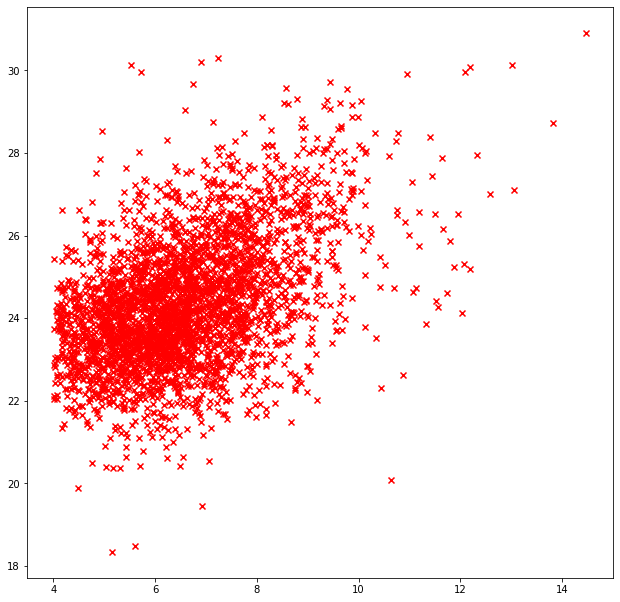

In [7]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(data['mRNA_TMM'],data['ProteinAUC'],marker='x',color='r')

#### Try not transforming embeddings?

In [8]:
def zscore(train_df):
    assert isinstance(train_df,pd.DataFrame)
    means = train_df.mean(axis=0)
    stds = train_df.std(axis=0)
    zscored = (train_df-means)/stds
    return zscored, means, stds

if ZSCORE:
    print(f'Data is z-scored')
    train, train_mean, train_std = zscore(train) #zscore data
    val = (val-train_mean)/train_std #zscore validation data using mean and std from train set
    test = (test-train_mean)/train_std #zscore test data using mean and std from train set

Data is z-scored


In [9]:
x_train = train.drop(columns=cols_drop).values
y_train = train[['ProteinAUC']].values

x_val = val.drop(columns=cols_drop).values
y_val = val[['ProteinAUC']].values

x_test = test.drop(columns=cols_drop).values
y_test = test[['ProteinAUC']].values

print(f'train dataset size: {x_train.shape}')
print(f'validation dataset size: {x_val.shape}')
print(f'test dataset size: {x_test.shape}')

train dataset size: (2641, 66)
validation dataset size: (331, 66)
test dataset size: (330, 66)


### Network Initialization

In [102]:
manifold_mlp = General_MLP([64,32,3],input_shape=(1,66),last=True,activation='relu')
manifold_mlp.summary()
title = f'../../29Atlas/mlp/results/training_50_epochs_64_32_3_1'
manifold_mlp.load_weights(f'{title}_modelweights')

Model: "general_mlp_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  4288      
_________________________________________________________________
dense_7 (Dense)              multiple                  2080      
_________________________________________________________________
dense_8 (Dense)              multiple                  99        
_________________________________________________________________
lambda_2 (Lambda)            multiple                  0         
Total params: 6,467
Trainable params: 6,467
Non-trainable params: 0
_________________________________________________________________


### Manifold GP and Kernel Initialization

Most people who set up a GP regression or classification model end up using the Squared-Exp or Rational Quadratic kernels. They are a quick-and-dirty solution that will probably work pretty well for interpolating smooth functions when N is a multiple of D, and when there are no 'kinks' in your function. If your function happens to have a discontinuity or is discontinuous in its first few derivatives (for example, the abs() function), then either your lengthscale will end up being extremely short, and your posterior mean will become zero almost everywhere, or your posterior mean will have 'ringing' effects. Even if there are no hard discontinuities, the lengthscale will usually end up being determined by the smallest 'wiggle' in your function - so you might end up failing to extrapolate in smooth regions if there is even a small non-smooth region in your data.

If your data is more than two-dimensional, it may be hard to detect this problem. One indication is if the lengthscale chosen by maximum marginal likelihood never stops becoming smaller as you add more data. This is a classic sign of model misspecification.

In [103]:
# base_kernel = gpflow.kernels.SquaredExponential(lengthscale=[1]*manifold_mlp.out_size) #Initialize ARD for lengthscale
base_kernel = gpflow.kernels.SquaredExponential(lengthscale=1) #No ARD for lengthscale

#base_kernel = gpflow.kernels.Matern52(lengthscale=[1]*manifold_mlp.out_size) #Initialize ARD for lengthscale

k = nn_based_kernel(base_kernel,manifold_mlp)
#print_summary(kernel)

model = gpflow.models.GPR(data=(x_train.astype('float32'), y_train.astype('float32')), kernel=k, mean_function=None)
model.likelihood.variance.assign(0.1)
print_summary(model)

name                                class             transform                prior    trainable    shape     dtype    value
----------------------------------  ----------------  -----------------------  -------  -----------  --------  -------  -----------------------------------------
GPR.kernel.model._layers[0][0]._trainable_weights[0]
GPR.kernel.model._layers[0][0].kernel
GPR.kernel.model.mlp_layers[0]._trainable_weights[0]
GPR.kernel.model.mlp_layers[0].kernel                                     ResourceVariable                                    True         (66, 64)  float32  [[0.29845098, 0.00674106, -0.04400715...
GPR.kernel.model._layers[0][0]._trainable_weights[1]
GPR.kernel.model._layers[0][0].bias
GPR.kernel.model.mlp_layers[0]._trainable_weights[1]
GPR.kernel.model.mlp_layers[0].bias                                     ResourceVariable                                    True         (64,)     float32  [-0.56396616, -0.92860895, -0.73091084...
GPR.kernel.model._layers[0][1

### GPR is not typically trained with stochastic/batch gradient descent
* Use all data typically to optimize marginal likelihood, (bfgs, conjugate gradients, full gradient descent)

In [104]:
#compare model.trainable_parameters to print_summary output
#what is difference between model.trainable_parameters and model.kernel.trainable_variables

#https://gpflow.readthedocs.io/en/latest/notebooks/models.html
#print_summary gives the untransformed parameters
#transform is softplus and the inverse given below
#np.log(1+np.e**0.54132485) = 1
#np.log((np.e**1)-1) = 0.54132485

### Unoptimized mapped values

In [105]:
x_unmapped = model.kernel.model(x_train.astype('float32')).numpy()
xtest_unmapped = model.kernel.model(x_test.astype('float32')).numpy()

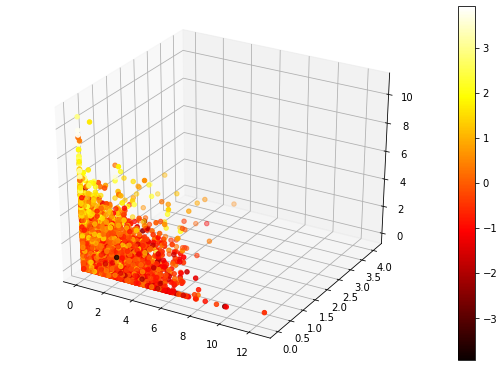

In [106]:
fig = plt.figure()
fig.set_size_inches(9.5,6.5)
ax = fig.add_subplot(111, projection='3d')

x = x_unmapped[:,0]
y = x_unmapped[:,1]
z = x_unmapped[:,2]
c = y_train[:,0]
# x = np.random.standard_normal(100)
# y = np.random.standard_normal(100)
# z = np.random.standard_normal(100)
# c = np.random.standard_normal(100)

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

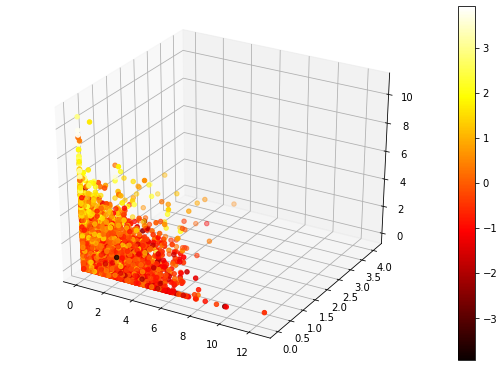

In [107]:
fig = plt.figure()
fig.set_size_inches(9.5,6.5)
ax = fig.add_subplot(111, projection='3d')

x = x_unmapped[:,0]
y = x_unmapped[:,1]
z = x_unmapped[:,2]
c = y_train[:,0]
# x = np.random.standard_normal(100)
# y = np.random.standard_normal(100)
# z = np.random.standard_normal(100)
# c = np.random.standard_normal(100)

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

# Optimization

https://stackoverflow.com/questions/42424444/scipy-optimisation-newton-cg-vs-bfgs-vs-l-bfgs

## Adam

#### Tracking kernel parameters

In [108]:
neg_likelihood = list()
neg_likelihood.append(-model.log_marginal_likelihood())

lengthscales = model.kernel.base_kernel.lengthscale.numpy().copy()
#np.vstack((model.kernel.base_kernel.lengthscale.numpy(),model.kernel.base_kernel.lengthscale.numpy()))

kernel_variance = list()
kernel_variance.append(model.kernel.base_kernel.variance.numpy())

model_variance = list()
model_variance.append(model.likelihood.variance.numpy())

validation_mse = list()
validation_pearson = list()

optimizer = tf.keras.optimizers.Adam()
regularizer = tf.keras.regularizers.l2(l=10)


#### Optimizing steps

In [109]:
ADAM = False
print(f'starting neg likelihood {-model.log_marginal_likelihood()}')
if ADAM:
    iterations = 2000
    
    for i in range(iterations):
        # disable automatic tracking by passing watch_accessed_variables=False
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            obj = -model.log_marginal_likelihood()
        grads = tape.gradient(obj, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        neg_likelihood.append(-model.log_marginal_likelihood())
        lengthscales = np.vstack((lengthscales,model.kernel.base_kernel.lengthscale.numpy().copy()))
        kernel_variance.append(model.kernel.base_kernel.variance.numpy())
        model_variance.append(model.likelihood.variance.numpy())
    
print(f'ending neg likelihood {-model.log_marginal_likelihood()}')

starting neg likelihood 7584.5244140625
ending neg likelihood 7584.5244140625


### BFGS? or L-BFGS-B

In [115]:
BFGS = True
print(f'starting neg likelihood {-model.log_marginal_likelihood()}')
if BFGS:
    opt = gpflow.optimizers.Scipy()

    def objective_closure():
        global lengthscales, x_val, y_val
        neg_likelihood.append(-model.log_marginal_likelihood())
        lengthscales = np.vstack((lengthscales,model.kernel.base_kernel.lengthscale.numpy().copy()))
        kernel_variance.append(model.kernel.base_kernel.variance.numpy())
        model_variance.append(model.likelihood.variance.numpy())
        
        mean, var = model.predict_f(x_val.astype('float32'))
        validation_mse.append(sklearn.metrics.mean_squared_error(mean.numpy(),y_val))
        validation_pearson.append(scipy.stats.pearsonr(mean.numpy().squeeze(),y_val.squeeze())[0])
        
        weight_penalty = 0
        for model_variables in model.trainable_variables:
            if 'dense' in model_variables.name and 'bias' not in model_variables.name:
                weight_penalty+=regularizer(model_variables)

        return - model.log_marginal_likelihood() + weight_penalty

    time_start = time.time()
    opt_logs = opt.minimize(objective_closure,
                            model.trainable_variables,
                            options=dict(maxiter=15))
    print(f'Run time {time.time()-time_start}')

print(f'ending neg likelihood {-model.log_marginal_likelihood()}')

starting neg likelihood 3385.6376953125
Run time 1.89601469039917
ending neg likelihood 2749.90185546875


In [116]:
## predict mean and variance of latent GP at test points
x_val = x_val.astype('float32')
mean, var = model.predict_f(x_val)
metrics = compute_metrics(mean.numpy(), y_val, y_val, fc_scale=2)
metrics

{'mae': 0.5859780594362912,
 'mse': 0.5377383015174519,
 'smse': 0.5385919562870822,
 'r2': 0.46140804371291777,
 'evs': 0.46641561775094964,
 'spearmanrho': 0.6793377299364998,
 'spearmanrho_p': 3.8858895396088035e-46,
 'pearsonr': 0.6882195715355433,
 'pearsonr_p': 8.995676308756496e-48,
 'median_abs_fc': 1.4090777961936203,
 'mean_abs_fc': 1.5010562692171883}

In [117]:
## predict mean and variance of latent GP at test points
mean, var = model.predict_f(x_train.astype('float32'))
metrics = compute_metrics(mean.numpy(), y_train, y_train, fc_scale=2)

# if SAVE:
#     pd.DataFrame.from_dict(metrics,orient='index').T.to_csv(f'./results/am04f0/metrics_{TITLE}.tsv',sep='\t')

metrics

{'mae': 0.5227742048798443,
 'mse': 0.45953762554117633,
 'smse': 0.45971169282357766,
 'r2': 0.5402883071764224,
 'evs': 0.5402883100802465,
 'spearmanrho': 0.704246439169561,
 'spearmanrho_p': 0.0,
 'pearsonr': 0.7350733146012963,
 'pearsonr_p': 0.0,
 'median_abs_fc': 1.338175320409361,
 'mean_abs_fc': 1.4367152997115267}

In [118]:
## predict mean and variance of latent GP at test points
mean, var = model.predict_f(x_test.astype('float32'))
metrics = compute_metrics(mean.numpy(), y_test, y_train, fc_scale=2)

# if SAVE:
#     pd.DataFrame.from_dict(metrics,orient='index').T.to_csv(f'./results/am04f0/metrics_{TITLE}.tsv',sep='\t')

metrics

{'mae': 0.5594016287518209,
 'mse': 0.5124165042166305,
 'smse': 0.4525055435678473,
 'r2': 0.5445754454414163,
 'evs': 0.5451945020867015,
 'spearmanrho': 0.7126050911228001,
 'spearmanrho_p': 1.9948497109603787e-52,
 'pearsonr': 0.740115107384852,
 'pearsonr_p': 1.7871908904646266e-58,
 'median_abs_fc': 1.367336386401091,
 'mean_abs_fc': 1.4736578771465252}

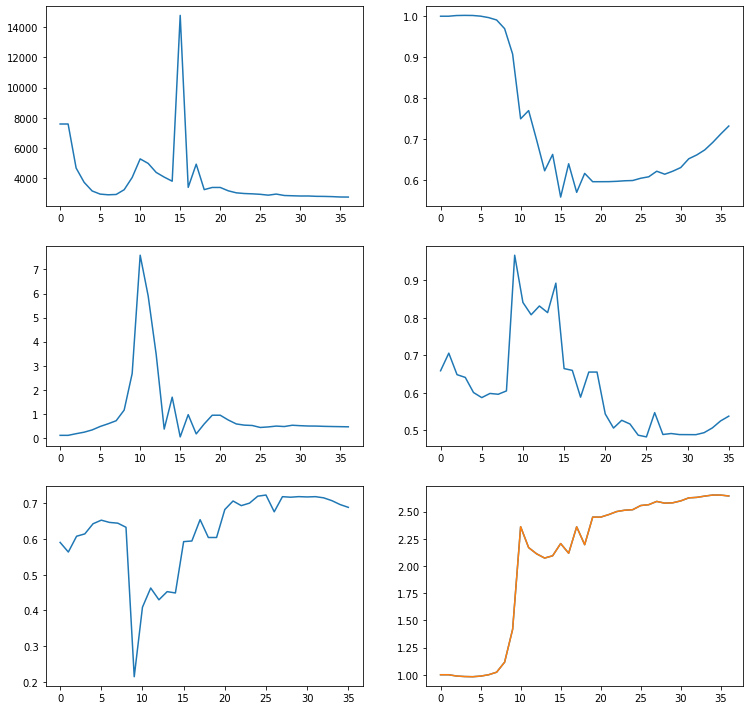

In [119]:
fig = plt.figure()
fig.set_size_inches(12.5,12.5)
ax = fig.add_subplot(321)
ax.plot(range(0,len(neg_likelihood)),neg_likelihood)

ax = fig.add_subplot(322)
ax.plot(range(0,len(kernel_variance)),kernel_variance)

ax = fig.add_subplot(323)
ax.plot(range(0,len(model_variance)),model_variance)

ax = fig.add_subplot(324)
ax.plot(range(0,len(validation_mse)),validation_mse)
ax = fig.add_subplot(325)
ax.plot(range(0,len(validation_pearson)),validation_pearson)
ax = fig.add_subplot(326)
ax.plot(range(0,len(lengthscales[:,0])),lengthscales[:,0])
for i in range(lengthscales.shape[1]):
    ax.plot(range(0,len(lengthscales[:,i])),lengthscales[:,i])

In [88]:
x_mapped = model.kernel.model(x_train).numpy()
xtest_mapped = model.kernel.model(x_test).numpy()
x_val_mapped = model.kernel.model(x_val).numpy()

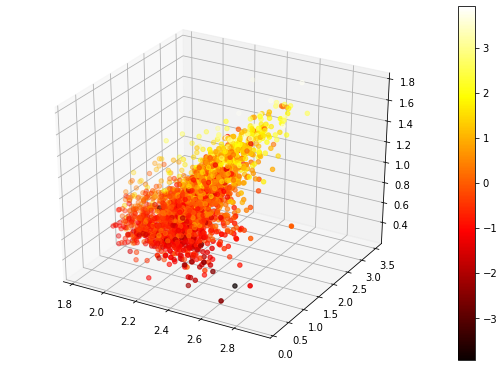

In [89]:
fig = plt.figure()
fig.set_size_inches(9.5,6.5)
ax = fig.add_subplot(111, projection='3d')

x = x_mapped[:,0]
y = x_mapped[:,1]
z = x_mapped[:,2]
c = y_train[:,0]
# x = np.random.standard_normal(100)
# y = np.random.standard_normal(100)
# z = np.random.standard_normal(100)
# c = np.random.standard_normal(100)

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

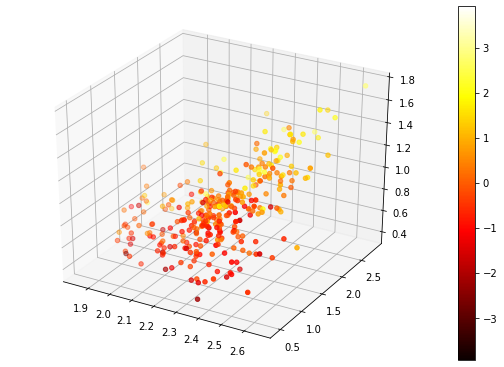

In [90]:
fig = plt.figure()
fig.set_size_inches(9.5,6.5)
ax = fig.add_subplot(111, projection='3d')

x = x_val_mapped[:,0]
y = x_val_mapped[:,1]
z = x_val_mapped[:,2]
c = y_val[:,0]
# x = np.random.standard_normal(100)
# y = np.random.standard_normal(100)
# z = np.random.standard_normal(100)
# c = np.random.standard_normal(100)

img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max())
fig.colorbar(img)
plt.show()

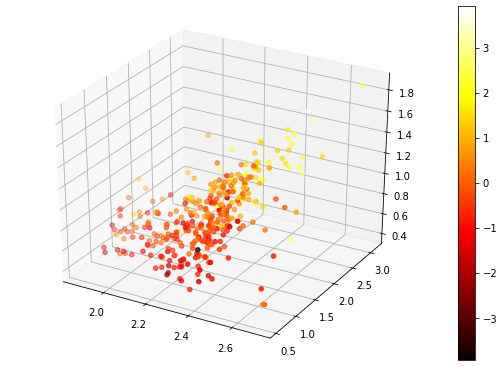

In [91]:
fig = plt.figure()
fig.set_size_inches(9.5,6.5)
ax = fig.add_subplot(111, projection='3d')

x = xtest_mapped[:,0]
y = xtest_mapped[:,1]
z = xtest_mapped[:,2]
c = y_test[:,0]
# x = np.random.standard_normal(100)
# y = np.random.standard_normal(100)
# z = np.random.standard_normal(100)
# c = np.random.standard_normal(100)

img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max())
fig.colorbar(img)
plt.show()

In [92]:
## predict mean and variance of latent GP at test points
mean, var = model.predict_f(x_test.astype('float32'))
metrics = compute_metrics(mean.numpy(), y_test, y_train, fc_scale=2)
metrics

{'mae': 0.5396944659070367,
 'mse': 0.5085954619504239,
 'smse': 0.4491312517692081,
 'r2': 0.5479715040338244,
 'evs': 0.5480251326548121,
 'spearmanrho': 0.7204695927585945,
 'spearmanrho_p': 4.4189506316662043e-54,
 'pearsonr': 0.7403312931205412,
 'pearsonr_p': 1.5908193856729586e-58,
 'median_abs_fc': 1.330713564925771,
 'mean_abs_fc': 1.4536646274859362}

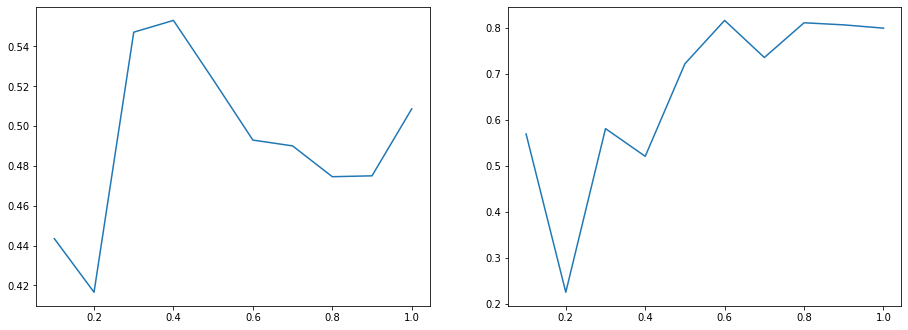

In [93]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]

scores=[]
percent = .1
intervals = np.arange(percent,1+percent,percent)

index_old = 0
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[index_old:index]
    top_means_ytruth = sorted_ytruth[index_old:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_train, fc_scale=2)['mse'])
    #index_old = index
    
fig = plt.figure()
fig.set_size_inches(15.5,5.5)
ax = fig.add_subplot(121)
ax.plot(intervals,scores)

scores=[]
index_old = 0
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[index_old:index]
    top_means_ytruth = sorted_ytruth[index_old:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_train, fc_scale=2)['pearsonr'])
    index_old = index
    
ax = fig.add_subplot(122)
ax.plot(intervals,scores)

0.5232569339882643


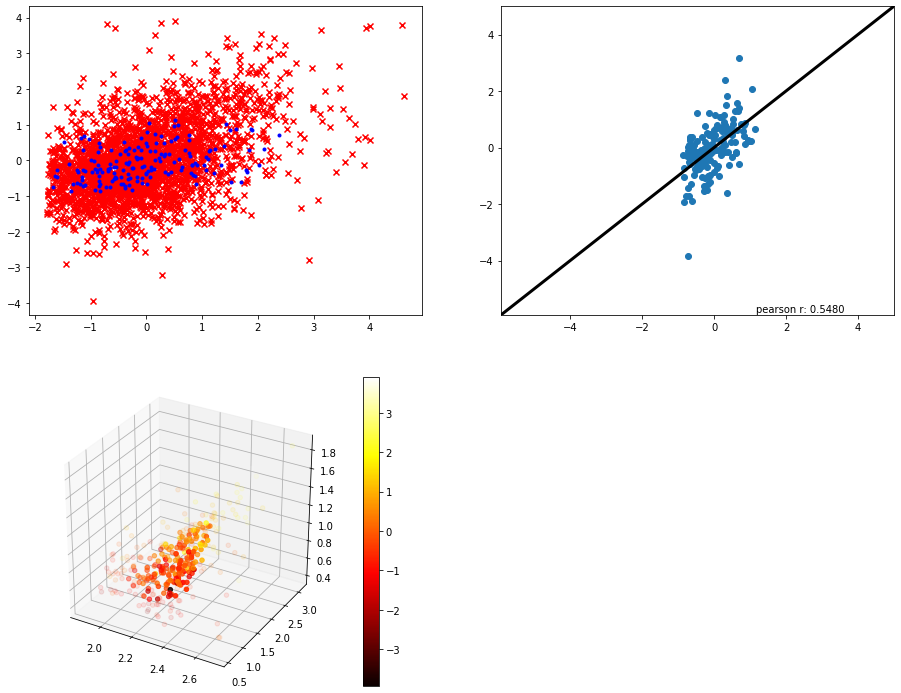

In [94]:
percent=.5
lower_percent=0
#could just use the sorted index and take the top x percent rather than sorting everything
index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))

x_sorted = x_test[sorted_indicies,0]

top_xvals = x_sorted[lower_index:index]
top_means = sorted_mean[lower_index:index]
top_means_ytruth = sorted_ytruth[lower_index:index]

print(sklearn.metrics.mean_squared_error(top_means_ytruth.squeeze(),top_means.squeeze()))

fig = plt.figure()
fig.set_size_inches(15.5,12.5)
ax = fig.add_subplot(221)
ax.scatter(x_train[:,0],y_train,marker='x',color='r')
ax.scatter(top_xvals,top_means.squeeze(),marker='.',color='b')

ax = fig.add_subplot(222)
ax.scatter(top_means,top_means_ytruth)
y_max = int(y_train.max())+2
y_min = y_train.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(top_means_ytruth.squeeze(),top_means.squeeze())[0]
# mse = sklearn.metrics.mean_squared_error(y_test,y_predicted)
ax.text(.65,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

#Lower
ax = fig.add_subplot(223, projection='3d')
x = xtest_mapped[sorted_indicies[lower_index:index],0]
y = xtest_mapped[sorted_indicies[lower_index:index],1]
z = xtest_mapped[sorted_indicies[lower_index:index],2]
c = y_test[sorted_indicies[lower_index:index],0]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max())
fig.colorbar(img)

#Upper
x = xtest_mapped[sorted_indicies[index::],0]
y = xtest_mapped[sorted_indicies[index::],1]
z = xtest_mapped[sorted_indicies[index::],2]
c = y_test[sorted_indicies[index::],0]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max(),alpha=0.1)


0.49393398991258336


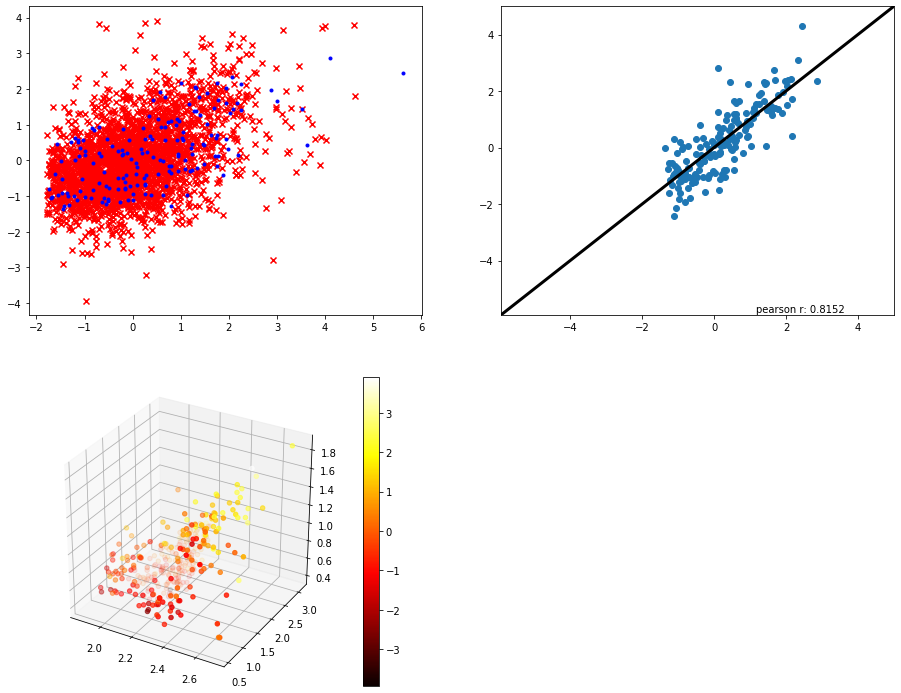

In [95]:
percent=1
lower_percent=0.5
index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))

x_sorted = x_test[sorted_indicies,0]

top_xvals = x_sorted[lower_index:index]
top_means = sorted_mean[lower_index:index]
top_means_ytruth = sorted_ytruth[lower_index:index]

print(sklearn.metrics.mean_squared_error(top_means_ytruth.squeeze(),top_means.squeeze()))


fig = plt.figure()
fig.set_size_inches(15.5,12.5)
ax = fig.add_subplot(221)
ax.scatter(x_train[:,0],y_train,marker='x',color='r')
ax.scatter(top_xvals,top_means.squeeze(),marker='.',color='b')

ax = fig.add_subplot(222)
ax.scatter(top_means,top_means_ytruth)
y_max = int(y_train.max())+2
y_min = y_train.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(top_means_ytruth.squeeze(),top_means.squeeze())[0]
ax.text(.65,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

#Lower
ax = fig.add_subplot(223, projection='3d')
x = xtest_mapped[sorted_indicies[0:lower_index],0]
y = xtest_mapped[sorted_indicies[0:lower_index],1]
z = xtest_mapped[sorted_indicies[0:lower_index],2]
c = y_test[sorted_indicies[0:lower_index],0]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max(),alpha=0.1)

#Upper
x = xtest_mapped[sorted_indicies[lower_index:index],0]
y = xtest_mapped[sorted_indicies[lower_index:index],1]
z = xtest_mapped[sorted_indicies[lower_index:index],2]
c = y_test[sorted_indicies[lower_index:index],0]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max())
fig.colorbar(img)


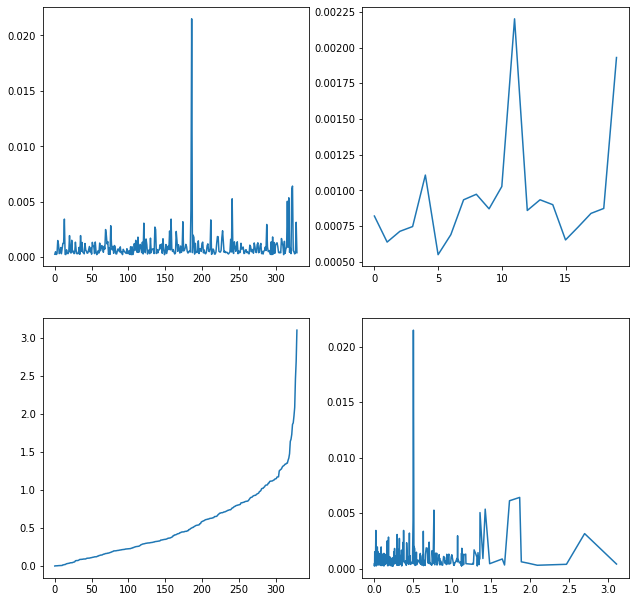

In [96]:
#Indicies of points with smallest error sorted
sorted_indicies_error = np.argsort(np.abs(y_test-mean.numpy()).squeeze())

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(221)
ax.plot(range(var.shape[0]),var.numpy()[sorted_indicies_error])

ax = fig.add_subplot(222)
moving_avg = []
percent = .05
intervals = np.arange(percent,1+percent,percent)
index_old = 0
for percent in intervals:
    index = int(np.floor(var.shape[0]*percent))
    moving_avg.append(np.mean(var.numpy()[sorted_indicies_error][index_old:index]))
    index_old = index
ax.plot(range(len(moving_avg)),moving_avg)

abs_error = np.abs(y_test-mean.numpy()).squeeze()
ax = fig.add_subplot(223)
ax.plot(abs_error[sorted_indicies_error])

#error vs variance
ax = fig.add_subplot(224)
ax.plot(abs_error[sorted_indicies_error],var.numpy()[sorted_indicies_error])

0.0008036155


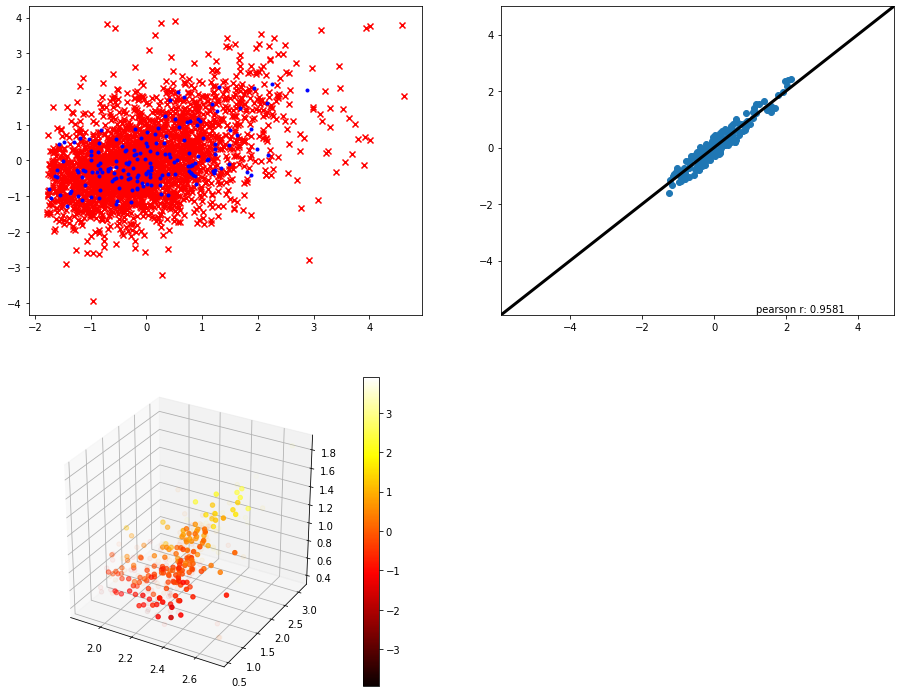

In [97]:
percent=0.5
lower_percent=0
index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))

x_sorted = x_test[sorted_indicies_error,0]
sorted_mean = mean.numpy()[sorted_indicies_error]
sorted_ytruth = y_test[sorted_indicies_error]

top_xvals = x_sorted[lower_index:index]
top_means = sorted_mean[lower_index:index]
top_means_ytruth = sorted_ytruth[lower_index:index]

fig = plt.figure()
fig.set_size_inches(15.5,12.5)
ax = fig.add_subplot(221)
ax.scatter(x_train[:,0],y_train,marker='x',color='r')
ax.scatter(top_xvals,top_means.squeeze(),marker='.',color='b')

ax = fig.add_subplot(222)
ax.scatter(top_means,top_means_ytruth)
y_max = int(y_train.max())+2
y_min = y_train.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(top_means_ytruth.squeeze(),top_means.squeeze())[0]
ax.text(.65,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

#Lower
ax = fig.add_subplot(223, projection='3d')
x = xtest_mapped[sorted_indicies_error[lower_index:index],0]
y = xtest_mapped[sorted_indicies_error[lower_index:index],1]
z = xtest_mapped[sorted_indicies_error[lower_index:index],2]
c = y_test[sorted_indicies_error[lower_index:index],0]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max())
fig.colorbar(img)

#Upper
x = xtest_mapped[sorted_indicies_error[index::],0]
y = xtest_mapped[sorted_indicies_error[index::],1]
z = xtest_mapped[sorted_indicies_error[index::],2]
c = y_test[sorted_indicies_error[index::],0]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max(),alpha=0.05)

print(var.numpy()[sorted_indicies_error][0:index].mean())

0.001103394


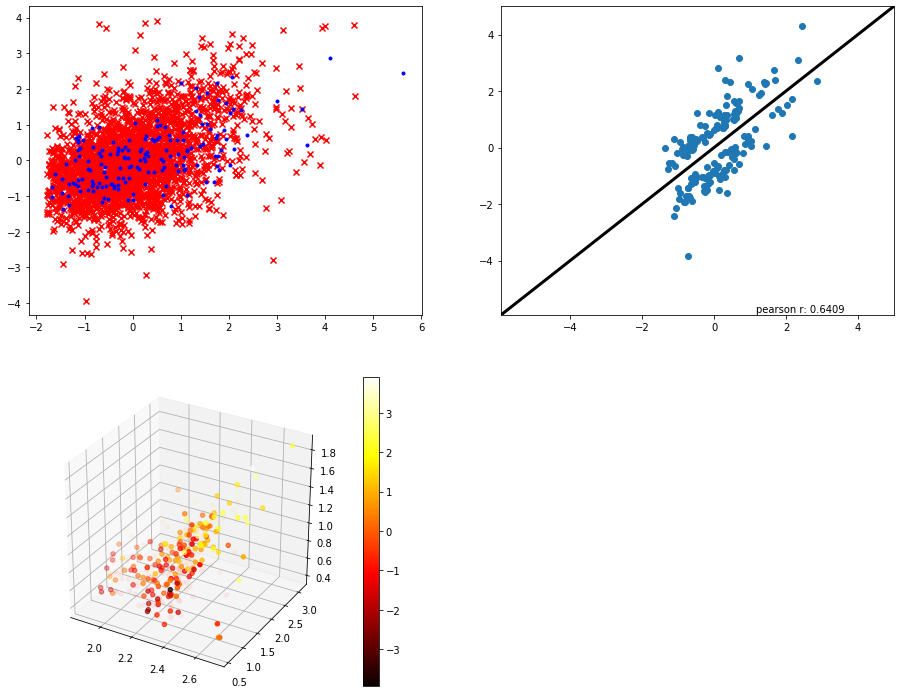

In [98]:
percent=1
lower_percent=0.5
index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))

x_sorted = x_test[sorted_indicies_error,0]
sorted_mean = mean.numpy()[sorted_indicies_error]
sorted_ytruth = y_test[sorted_indicies_error]

top_xvals = x_sorted[lower_index:index]
top_means = sorted_mean[lower_index:index]
top_means_ytruth = sorted_ytruth[lower_index:index]

fig = plt.figure()
fig.set_size_inches(15.5,12.5)
ax = fig.add_subplot(221)
ax.scatter(x_train[:,0],y_train,marker='x',color='r')
ax.scatter(top_xvals,top_means.squeeze(),marker='.',color='b')

ax = fig.add_subplot(222)
ax.scatter(top_means,top_means_ytruth)
y_max = int(y_train.max())+2
y_min = y_train.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(top_means_ytruth.squeeze(),top_means.squeeze())[0]
ax.text(.65,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

#Lower
ax = fig.add_subplot(223, projection='3d')
x = xtest_mapped[sorted_indicies_error[0:lower_index],0]
y = xtest_mapped[sorted_indicies_error[0:lower_index],1]
z = xtest_mapped[sorted_indicies_error[0:lower_index],2]
c = y_test[sorted_indicies_error[0:lower_index],0]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max(),alpha=0.05)

#Upper
x = xtest_mapped[sorted_indicies_error[lower_index:index],0]
y = xtest_mapped[sorted_indicies_error[lower_index:index],1]
z = xtest_mapped[sorted_indicies_error[lower_index:index],2]
c = y_test[sorted_indicies_error[lower_index:index],0]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), vmin = y_train[:,0].min(), vmax = y_train[:,0].max())
fig.colorbar(img)

print(var.numpy()[sorted_indicies_error][lower_index:index].mean())

In [95]:
#plt.close("all")

In [68]:
#mRNA is already log2 transformed
MISSING_PROT = data_dir + 'missing_proteins/rna_missing_protein_u64embeddings.pkl'
with open(MISSING_PROT,'rb') as file:
    rna_missing_prot_embed = pickle.load(file)

In [69]:
cell_lines = list(rna_prot_embed.keys())
print(cell_lines)

for cell in cell_lines:
    rna_missing_prot_embed[cell]['seq_length'] = np.log2(rna_missing_prot_embed[cell]['seq_length']+1)

['AT2_04M_F0', 'AT2_04M_F10', 'AT2_18M_F0', 'AT2_18M_F10', 'AM_04M_F0', 'AM_04M_F10', 'AM_18M_F0', 'AM_18M_F10']


In [70]:
infer = rna_missing_prot_embed['AM_04M_F0'][['AM_04M_F0','seq_length']+list(range(64))].copy()
infer.rename(columns={'AM_04M_F0': 'mRNA_TMM', 'seq_length': 'ProteinLength'},inplace=True)

#zscore using mean and std from train
infer = (infer-train_mean[train_mean.index!='ProteinAUC'])/train_std[train_std.index!='ProteinAUC']
x_infer = infer.values
mean_inf, var_inf = model.predict_f(x_infer.astype('float32'))

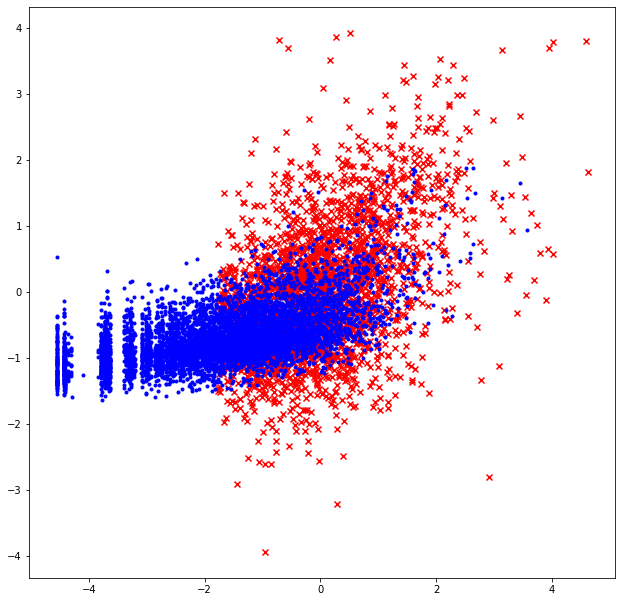

In [99]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(x_train[:,0],y_train,marker='x',color='r')
ax.scatter(x_infer[:,0],mean_inf.numpy(),marker='.',color='b')

In [121]:
x_infer.shape

(6179, 66)

Text(0.65, 0.01, 'pearson r: 0.7366')

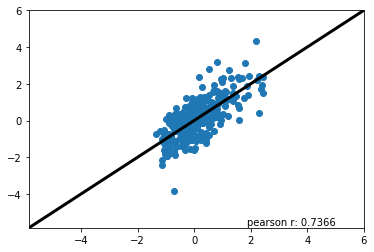

In [50]:
fig = plt.figure()
#fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(mean.numpy(),y_test)
y_max = int(y_test.max())+2
y_min = y_test.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(y_test.squeeze(),mean.numpy().squeeze())[0]
ax.text(.65,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

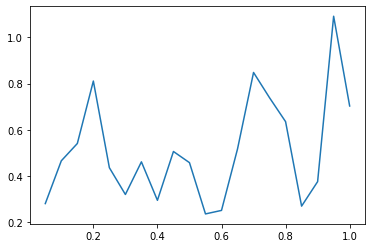

In [123]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]

scores=[]

percent = .05
intervals = np.arange(percent,1+percent,percent)

index_old = 0
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[index_old:index]
    top_means_ytruth = sorted_ytruth[index_old:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_train, fc_scale=2)['mse'])
    index_old = index
    
fig = plt.figure()
#fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.plot(intervals,scores)
if SAVE:
    fig.savefig(f"./results/am04f0/smse_{TITLE}.pdf")

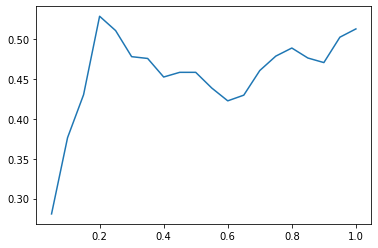

In [126]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]

scores=[]

intervals = np.arange(.05,1.05,0.05)

index_old = 0
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[index_old:index]
    top_means_ytruth = sorted_ytruth[index_old:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_train, fc_scale=2)['mse'])
    #print(metrics.mean_squared_error(top_means_ytruth,top_means))
    #index_old = index
    
fig = plt.figure()
#fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.plot(intervals,scores)
if SAVE:
    fig.savefig(f"./results/am04f0/smse_{TITLE}.pdf")

Text(0.75, 0.01, 'pearson r: 0.9006')

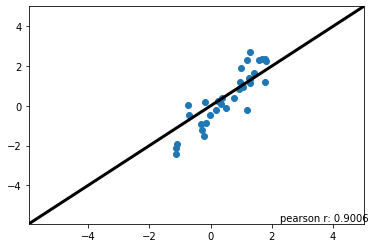

In [74]:
percent=.9
lower_percent=.8
index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))
top_means = sorted_mean[lower_index:index]
top_means_ytruth = sorted_ytruth[lower_index:index]

fig = plt.figure()
#fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(top_means,top_means_ytruth)
y_max = int(y_train.max())+2
y_min = y_train.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(top_means_ytruth.squeeze(),top_means.squeeze())[0]
ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

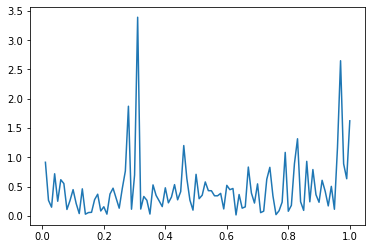

In [75]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]

scores=[]

intervals = np.arange(.01,1.01,0.01)

index_old = 0
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[index_old:index]
    top_means_ytruth = sorted_ytruth[index_old:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_train, fc_scale=2)['mse'])
    #print(metrics.mean_squared_error(top_means_ytruth,top_means))
    index_old = index
    
fig = plt.figure()
#fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.plot(intervals,scores)

Text(0.75, 0.01, 'pearson r: 0.5725')

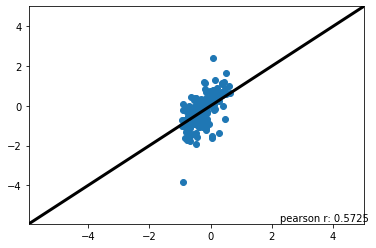

In [76]:
percent=.5
lower_percent=0
index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))
top_means = sorted_mean[lower_index:index]
top_means_ytruth = sorted_ytruth[lower_index:index]

fig = plt.figure()
#fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(top_means,top_means_ytruth)
y_max = int(y_train.max())+2
y_min = y_train.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(top_means_ytruth.squeeze(),top_means.squeeze())[0]
ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

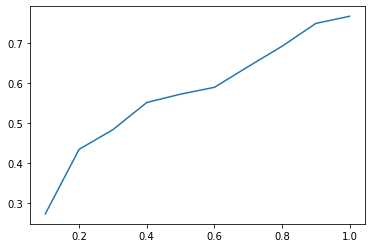

In [77]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]

scores=[]

intervals = np.arange(.1,1.1,0.1)
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[0:index]
    top_means_ytruth = sorted_ytruth[0:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_train, fc_scale=2)['pearsonr'])
    #print(metrics.mean_squared_error(top_means_ytruth,top_means))
    
fig = plt.figure()
#fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.plot(intervals,scores)

    

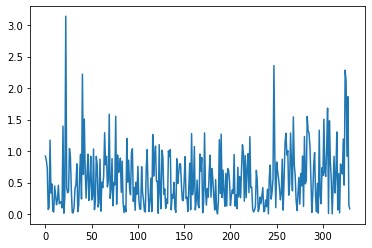

In [57]:
plt.plot(np.abs(sorted_mean-sorted_ytruth))